# Figure 1

This notebook generates Figure 1 from the paper.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

import viz_utils
import data_utils

mpl.rc('image', cmap='viridis')
plt.ion()
normal_font = {'family' : 'DejaVu Sans',
        'weight' : 'medium',
        'size'   : 6}
stats_font = {'family' : 'DejaVu Sans',
        'weight' : 'medium',
        'size'   : 6}
plt.rc('font', **normal_font)

pd.set_option('display.max_columns', None)

print('Path to dataset:', data_utils.butter_data_path())

Path to dataset: s3://oedi-data-lake/butter


# 1. Load Data
Please see README.md for instructions on how to obtain this dataset

In [2]:
## Multiple shapes only for depth=3
filters_shapes = [
    ('dataset', 'in', ['201_pol','529_pollen','537_houses','connect_4','mnist','sleep','wine_quality_white']),
    ('shape', 'in', ['exponential','rectangle','trapezoid','rectangle_residual']),
    ('learning_rate', '<=', 0.00011),
    ('learning_rate', '>=', 0.00009),
    ('depth', '==', 3),
    ('label_noise', '==', 0.0),
    ('num_runs', '>=', 20)
]

## Multiple depths only for rectangle
filters_depths = [
    ('dataset', 'in', ['201_pol','529_pollen','537_houses','connect_4','mnist','sleep','wine_quality_white']),
    ('shape', '==', 'rectangle'),
    ('learning_rate', '<=', 0.00011),
    ('learning_rate', '>=', 0.00009),
    ('depth', 'in', [2,5,8]),
    ('label_noise', '==', 0.0),
    ('num_runs', '>=', 20)
]

columns = [
    "test_loss_median",
    "test_loss_stddev",
    "test_loss_avg",
    "experiment_id",
    "size",
    "num_free_parameters",
    'dataset',
    'epochs',
    'shape',
    'depth',
]

primary_sweep_summary_shapes = data_utils.read_pandas('primary_sweep_summary', columns=columns, filters=filters_shapes)
primary_sweep_summary_depths = data_utils.read_pandas('primary_sweep_summary', columns=columns, filters=filters_depths)

# 2. Extract into long-format dataframe

In [3]:
def extract_data(original_df, downsample_epochs=False, grouper='shape'):

    original_df['epoch'] = original_df['test_loss_median'].apply(lambda x: list(range(1, 1 + len(x))))

    epoch_wise_values = ["test_loss_median", "test_loss_avg", "test_loss_stddev", "epoch"]

    df = original_df.explode(epoch_wise_values)

    for value in epoch_wise_values:
        df[value] = df[value].astype("float32")
    df["epoch"] = df["epoch"].astype("int")

    #downsample by epoch logarithmically
    if downsample_epochs:
        keep_epochs = np.unique(np.logspace(0,np.log10(3000),100,base=10).astype(int))
        df = df[df["epoch"].isin(keep_epochs)]

    # num_free_parameters is not unique in sizes. Take first experiment
    df = df.sort_values('experiment_id').groupby(['dataset',grouper,'num_free_parameters','epoch']).first().reset_index()
    return df

primary_sweep_summary_shapes_expanded = extract_data(primary_sweep_summary_shapes, downsample_epochs=True, grouper='shape')
primary_sweep_summary_depths_expanded = extract_data(primary_sweep_summary_depths, downsample_epochs=True, grouper='depth')

# 3. Preprocess the variables we want to plot

In [4]:
def preprocess_variables(df, group_by=[]):

    #test_loss_median_processed
    df['test_loss_median_processed'] = df['test_loss_median']

    grouper = df.groupby(group_by)['test_loss_median_processed']
    mins = grouper.transform('min')
    df['test_loss_median_processed'] = -np.log10(np.minimum(2,df['test_loss_median_processed'] / mins).astype(float)-(1-1e-1))

    grouper = df.groupby(group_by)['test_loss_median_processed']
    mins = grouper.transform('min')
    maxs = grouper.transform('max')
    df['test_loss_median_processed'] = (df['test_loss_median_processed'] - mins)/(maxs-mins)

    #test_loss_median_processed_nocap
    df['test_loss_median_processed_nocap'] = df['test_loss_median']

    grouper = df.groupby(group_by)['test_loss_median_processed_nocap']
    mins = grouper.transform('min')
    df['test_loss_median_processed_nocap'] = -np.log10(df['test_loss_median_processed_nocap'] / mins).astype(float)-(1-1e-1)

    grouper = df.groupby(group_by)['test_loss_median_processed_nocap']
    mins = grouper.transform('min')
    maxs = grouper.transform('max')
    df['test_loss_median_processed_nocap'] = (df['test_loss_median_processed_nocap'] - mins)/(maxs-mins)
    
    #test_loss_cov
    df['test_loss_cov'] = df['test_loss_stddev']/df['test_loss_avg']

    #test_loss_cov_processed
    df['test_loss_cov_processed'] = np.log1p(10*df['test_loss_cov'])
    grouper = df.groupby(group_by)['test_loss_cov_processed']
    mins = grouper.transform('min')
    maxs = grouper.transform('max')
    df['test_loss_cov_processed'] = (df['test_loss_cov_processed'] - mins)/(maxs-mins)

    return df

primary_sweep_summary_shapes_processed = preprocess_variables(primary_sweep_summary_shapes_expanded, group_by=['dataset'])
primary_sweep_summary_depths_processed = preprocess_variables(primary_sweep_summary_depths_expanded, group_by=['dataset'])

# 4. Plot the Butter Zone

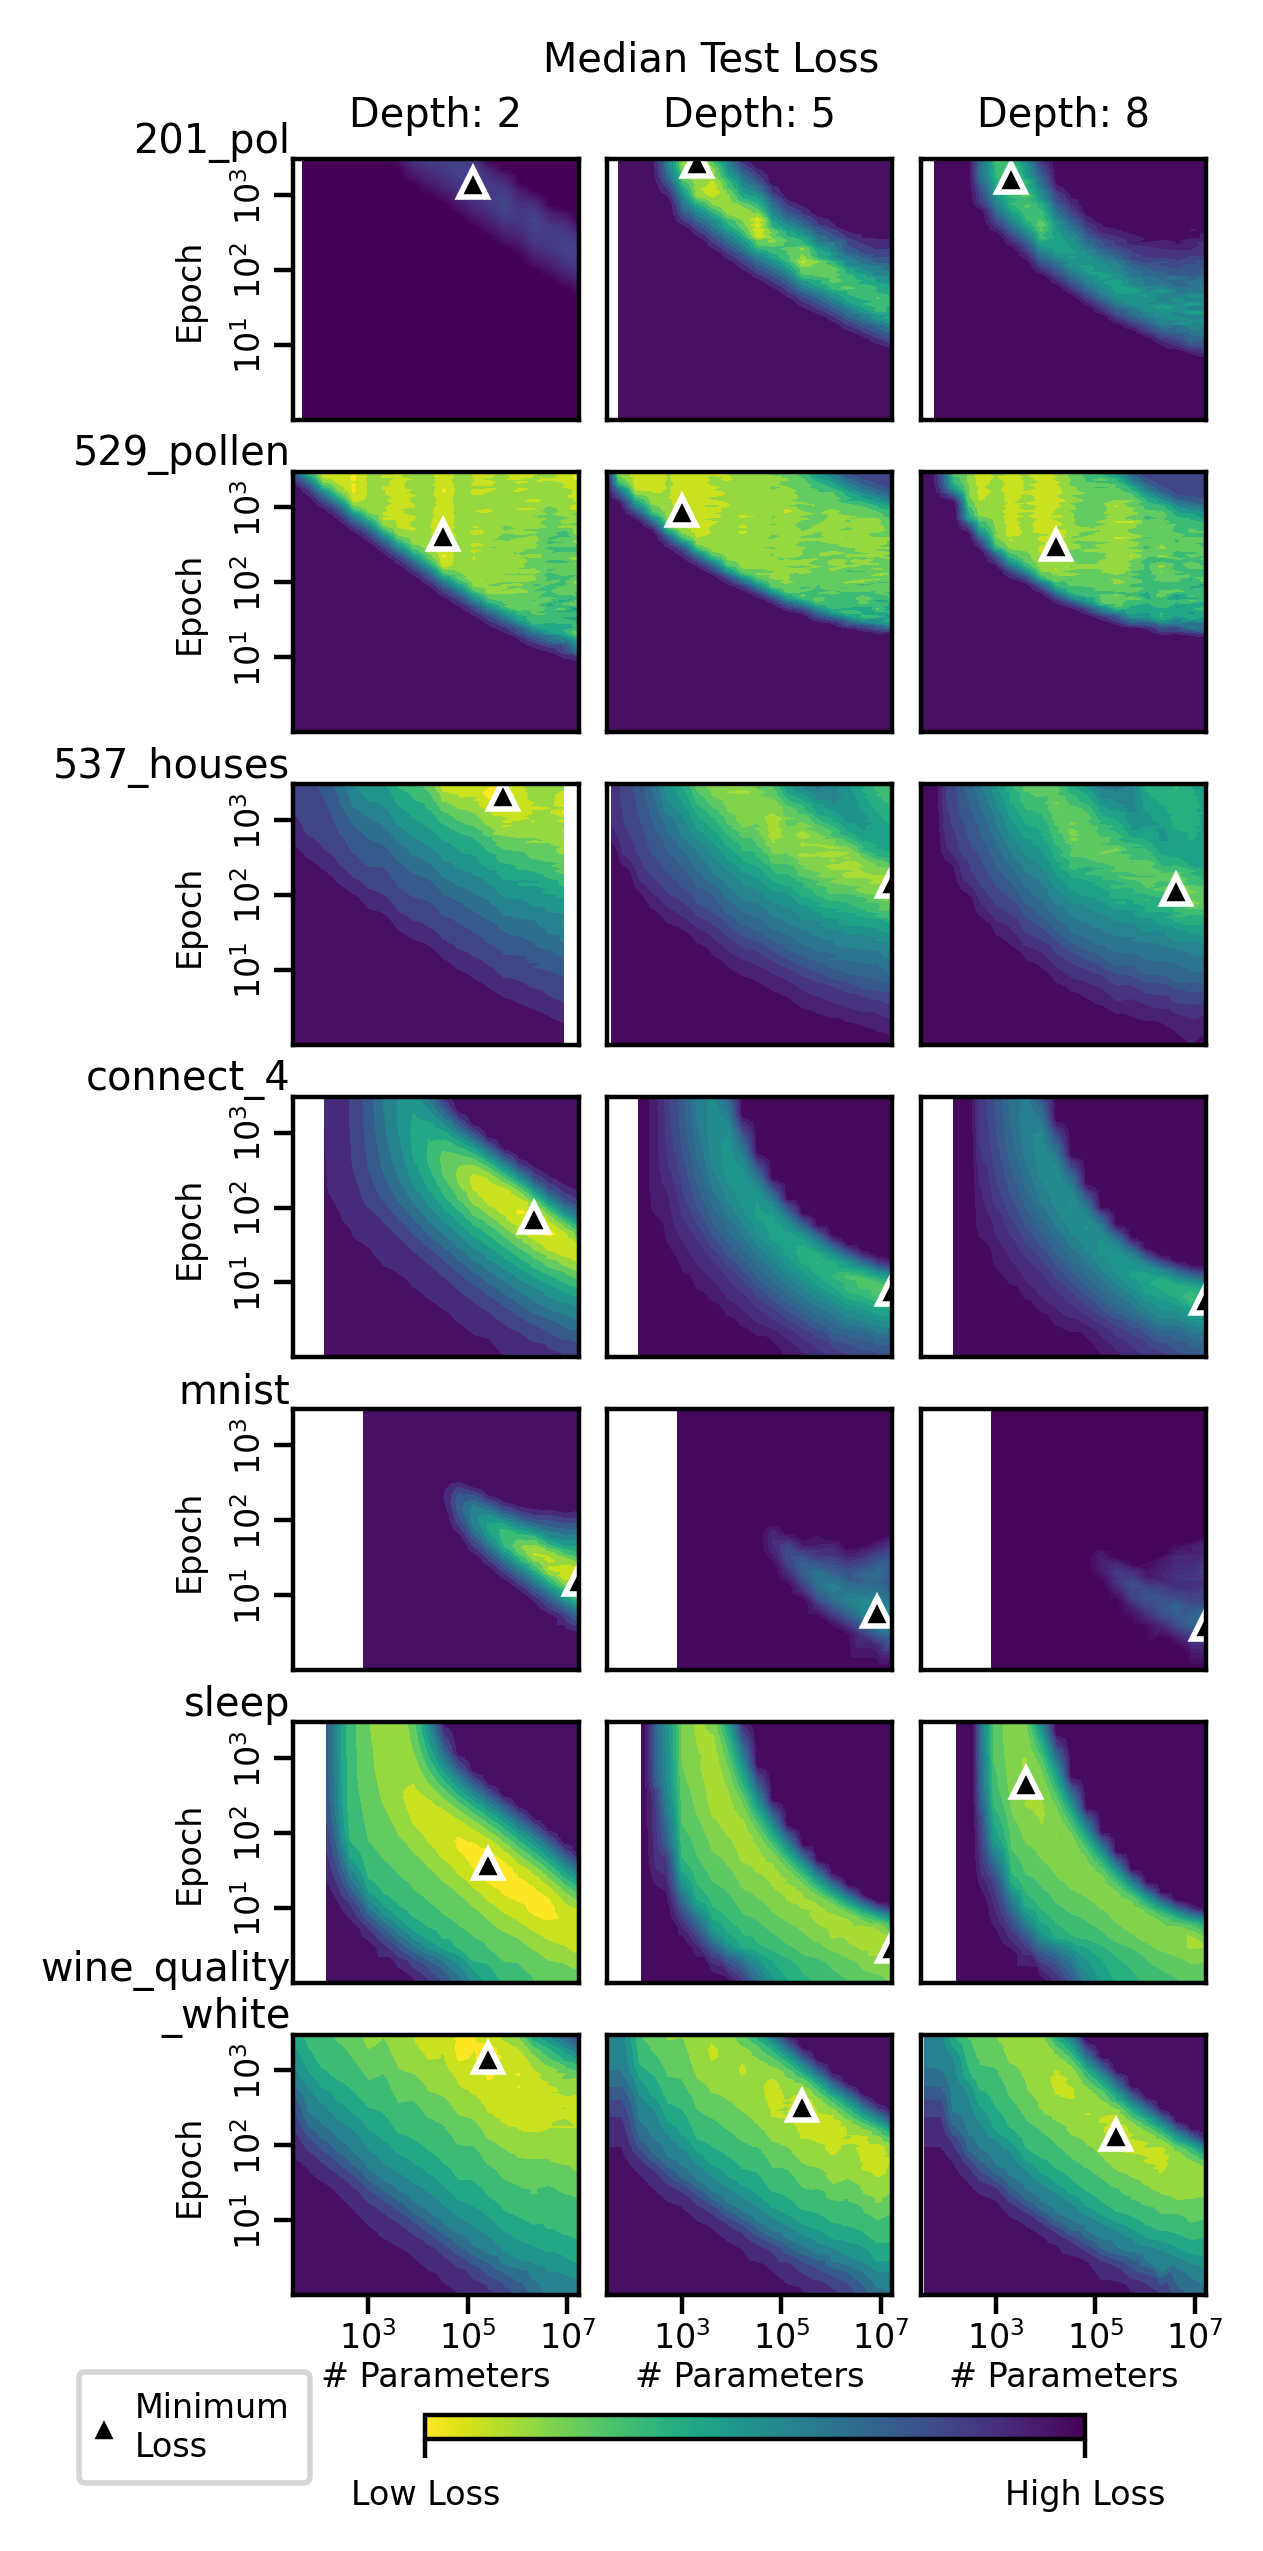

In [5]:
landmarks = []

title = 'Median Test Loss'
fig = plt.figure(dpi=400, figsize=(5.5/2,6))
viz_utils.do_grid(primary_sweep_summary_depths_processed, {
                    'epoch': '**Y**',
                    'dataset': '**GY**',
                    'depth': '**GX**',
                    'num_free_parameters': '**X**'
                    },'test_loss_median_processed',
                    log_z=False,
                    plot_data_points=False,
                  xlim=(2**5,16783426),vmin=0,vmax=1,
                  xticks=[10**3,10**5,10**7],
                  yticks=[10**1,10**2,10**3],
                  hide_spine="right",
                  xlabel_transform = lambda x: f"Depth: {x}",
                  plot_landmarks="maximum",
                  landmarks=landmarks,
                  row_label_as_title=True)
                  
plt_axs = fig.gca()

plt.suptitle(title,y=1)

cax = fig.add_axes([0.24, 0, 0.6, 0.01])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="viridis_r"),cax=cax,
                    orientation='horizontal',ticks=[0,1])
cbar.ax.set_xticklabels(['Low Loss', 'High Loss'])

lax = fig.add_axes([-0.02, 0, 0.1, 0.01])
plt.axis('off')
legend_elements = [Line2D([0], [0], markerfacecolor='black', markeredgecolor='white', marker="^", 
                         label='Minimum\nLoss', markeredgewidth=1, markersize=5, color='white')]
lax.legend(handles=legend_elements, loc="center", borderpad=0.6, handlelength=0.3)

plt.show()

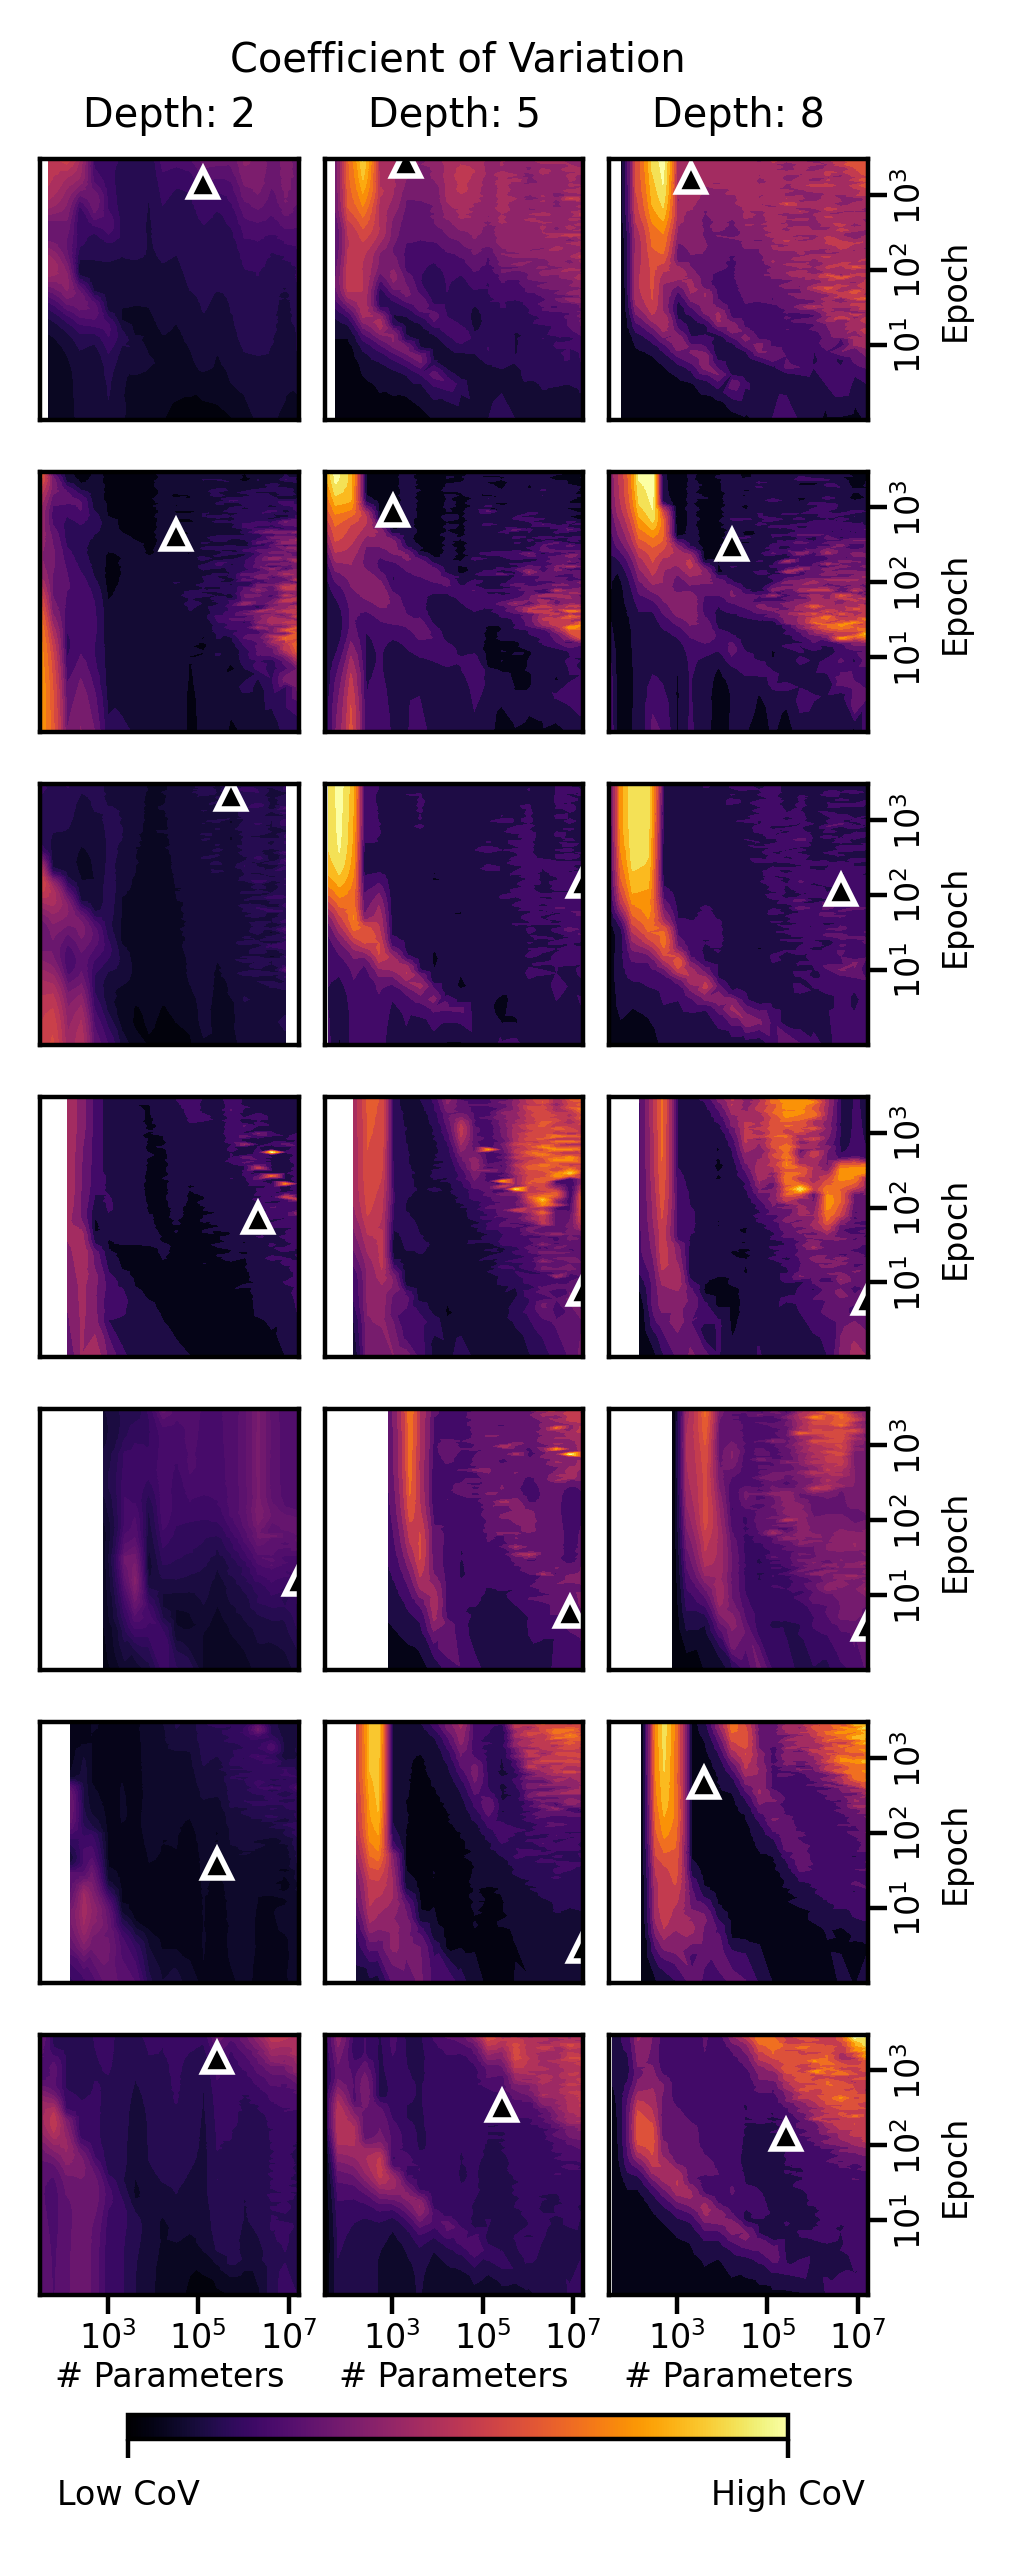

In [6]:
title = 'Coefficient of Variation'
fig = plt.figure(dpi=400, figsize=(5.5/2,6))
viz_utils.do_grid(primary_sweep_summary_depths_processed, {
                    'epoch': '**Y**',
                    'dataset': '**GY**',
                    'depth': '**GX**',
                    'num_free_parameters': '**X**'
                    },'test_loss_cov_processed',
                    log_z=False,
                    plot_data_points=False,
                  xlim=(2**5,16783426),vmin=0,vmax=1,
                  xticks=[10**3,10**5,10**7],
                  yticks=[10**1,10**2,10**3],
                  hide_spine="left",
                  xlabel_transform = lambda x: f"Depth: {x}",
                  plot_landmarks="from_list",
                  landmarks=landmarks,
                  row_label_as_title=True,
                  cmap="inferno",)
plt.suptitle(title,y=1)

cax = fig.add_axes([0.2, 0, 0.6, 0.01])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="inferno"),cax=cax,
                    orientation='horizontal',ticks=[0,1])
cbar.ax.set_xticklabels(['Low CoV', 'High CoV'])
#plt.subplots_adjust(top=0.96,bottom=0.06)
plt.show()
